In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler


# Gasoline RBOB

## 7:3

In [2]:
# Đọc dữ liệu
df = pd.read_csv('Gasoline RBOB Futures Historical Data.csv').dropna()

In [3]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)


In [4]:
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-27,2.6847,2.6878,2.6976,2.6877,0.15K,-0.59%
1,2024-03-26,2.7006,2.7489,2.7500,2.6980,0.39K,-1.74%
2,2024-03-25,2.7484,2.7370,2.7603,2.7310,0.62K,1.11%
3,2024-03-22,2.7398,2.7090,2.7456,2.7090,0.61K,0.47%
4,2024-03-21,2.7271,2.7370,2.7376,2.7119,0.15K,-0.22%


In [5]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df = df.iloc[::-1].reset_index(drop=True)

In [6]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,1.4150,1.3136,1.3790,1.2685,87520,7.81
1,2019-01-03,1.4377,1.3160,1.3676,1.3016,57750,1.60
2,2019-01-04,1.4515,1.3364,1.3981,1.3293,66360,0.96
3,2019-01-07,1.4505,1.3560,1.3945,1.3389,79090,5.95
4,2019-01-08,1.4740,1.3466,1.3722,1.3385,74920,1.62
...,...,...,...,...,...,...,...
1325,2024-03-21,2.7271,2.7370,2.7376,2.7119,150,-0.22
1326,2024-03-22,2.7398,2.7090,2.7456,2.7090,610,0.47
1327,2024-03-25,2.7484,2.7370,2.7603,2.7310,620,1.11
1328,2024-03-26,2.7006,2.7489,2.7500,2.6980,390,-1.74


In [7]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [9]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [10]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])



In [11]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [13]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07732644566544256
MAPE trên tập test là: 2.4424420484488887 %
MAE trên tập test là: 0.05885949868073869


In [14]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)



[[2.695994]
 [2.702636]
 [2.718559]
 [2.735432]
 [2.759051]
 [2.766731]
 [2.782141]
 [2.792642]
 [2.788723]
 [2.78629 ]
 [2.781213]
 [2.785716]
 [2.785656]
 [2.783257]
 [2.788081]
 [2.787257]
 [2.788961]
 [2.783023]
 [2.780298]
 [2.778657]
 [2.782815]
 [2.786436]
 [2.787969]
 [2.785237]
 [2.782792]
 [2.780029]
 [2.784233]
 [2.785567]
 [2.786952]
 [2.786093]]


In [15]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.695994
1331,2.702636
1332,2.718559
1333,2.735432
1334,2.759051
1335,2.766731
1336,2.782141
1337,2.792642
1338,2.788723
1339,2.786290


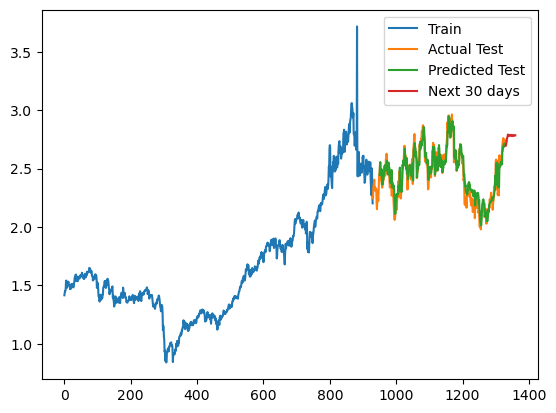

In [16]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('Gasoline_RBOB_73_Fix.png') 
plt.show()


## 8:2

In [17]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [18]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


In [19]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [20]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [21]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07152744954478744
MAPE trên tập test là: 2.152776413406676 %
MAE trên tập test là: 0.05291352845528458


In [22]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07152744954478744
MAPE trên tập test là: 2.152776413406676 %
MAE trên tập test là: 0.05291352845528458


In [23]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[2.685312]
 [2.688227]
 [2.696096]
 [2.714283]
 [2.746367]
 [2.759966]
 [2.770402]
 [2.769428]
 [2.772245]
 [2.774571]
 [2.773473]
 [2.772243]
 [2.772117]
 [2.771916]
 [2.771766]
 [2.769372]
 [2.772664]
 [2.771407]
 [2.772907]
 [2.770414]
 [2.769785]
 [2.769129]
 [2.768511]
 [2.769028]
 [2.771287]
 [2.771214]
 [2.771611]
 [2.772336]
 [2.77142 ]
 [2.771939]]


In [24]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.685312
1331,2.688227
1332,2.696096
1333,2.714283
1334,2.746367
1335,2.759966
1336,2.770402
1337,2.769428
1338,2.772245
1339,2.774571


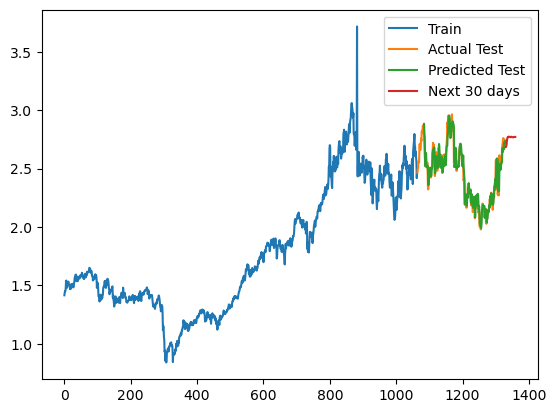

In [25]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()

plt.show()

### 9:1

In [24]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [25]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [26]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [28]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.0669174647982613
MAPE trên tập test là: 2.08267499583709 %
MDA trên tập test là: 46.42857142857143 %


In [29]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[2.670085]
 [2.675672]
 [2.687254]
 [2.692529]
 [2.734331]
 [2.749598]
 [2.769408]
 [2.779477]
 [2.787122]
 [2.779309]
 [2.76644 ]
 [2.763758]
 [2.769028]
 [2.770097]
 [2.768767]
 [2.771968]
 [2.773195]
 [2.77423 ]
 [2.771196]
 [2.773239]
 [2.773381]
 [2.771542]
 [2.772484]
 [2.774262]
 [2.776556]
 [2.781137]
 [2.777781]
 [2.778943]
 [2.778901]
 [2.778381]]


In [30]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.670085
1331,2.675672
1332,2.687254
1333,2.692529
1334,2.734331
1335,2.749598
1336,2.769408
1337,2.779477
1338,2.787122
1339,2.779309


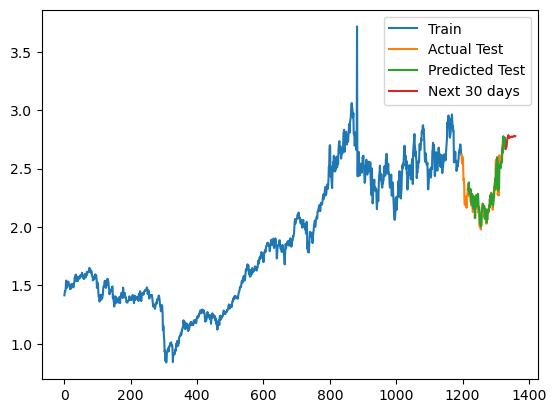

In [31]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()